# CS145: Project 3 | Project Name

## Collaborators:
Please list the names and SUNet IDs of your collaborators below:
* *Muhammad Zubair, 2018-CE-230
* *Hanan Anjum, 2018-CE-216

**Setting Up BigQuery and Dependencies**

In [ ]:
# Run this cell to authenticate yourself to BigQuery
from google.colab import auth
auth.authenticate_user()
project_id = "db-prj1"

In [ ]:
# Initialize BiqQuery client
from google.cloud import bigquery
client = bigquery.Client(project=project_id)

In [ ]:
# Add imports for any visualization libraries you may need
import matplotlib.pyplot as plt

%matplotlib inline

## Project Overview

---

The aim of our project is to go through “Querying, Visualizing, Predicting -- The Full Data Cycle” after selecting appropriate dataset from Bigquery. 

We will work on following Research Question:
   
   "*Given a project information, what is its ranking(popularity level)?*"


We will analyze different features of a Project in Bigquery dataset 'libraries.io', and select some important features that could help in predicting the 'Ranking' of project.


Finally, we will use Bigquery AI to train a model that predicts the 'Ranking' of a project.


---


## Analysis of Dataset

---

We have selected a table named “projects” in “libraries.io” bigquery public dataset.

Dataset description:


*   Libraries.io gathers data on open source software from 33 package managers and 3 source code repositories. It track over 2.4m unique open source projects, 25m repositories and 121m interdependencies between them. This gives Libraries.io a unique understanding of open source software.
*   We find data about software distributed and/or crafted publicly on the Internet.
*   We will find information about its development, its distribution and its relationship with other software included as a dependency.
*   There is no information about the individuals who create and maintain these projects

Dataset size & complexity:


*   7 tables total, we will only use 2
*   projects table(size=900mb)
*   repositories table(size=6gb) 

Tables organization:
*   projects table contain 

---


## Data Exploration

---

**--> Maximum and Minimum Ranking of Projects**

----

In [ ]:
%%bigquery --project $project_id
SELECT max(sourcerank) as maximum_ranking, min(sourcerank) as minimum_ranking FROM `bigquery-public-data.libraries_io.projects`

,maximum_ranking,minimum_ranking
0,34,0


**--> Ranking Distribution**

In [ ]:
%%bigquery --project $project_id ranking_dist

SELECT
  sourcerank,
  count(*) no_rows
FROM
  `bigquery-public-data.libraries_io.projects`
  group by sourcerank

Text(0, 0.5, 'ranking')

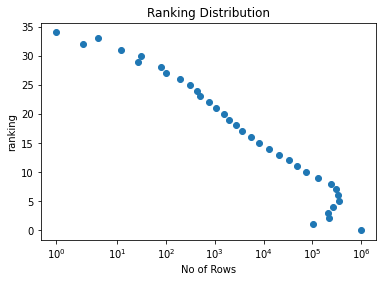

In [ ]:
plt.figure()
plt.scatter(ranking_dist["no_rows"], ranking_dist["sourcerank"])
plt.title("Ranking Distribution")
plt.xscale('symlog')
plt.xlabel("No of Rows")
plt.ylabel("ranking")

**--> Exploring important features that determine Ranking**

***1) Dependent_projects_count relation with Ranking***

In [ ]:
%%bigquery --project $project_id dependent_prj

SELECT sourcerank,dependent_projects_count FROM `bigquery-public-data.libraries_io.projects`

Text(0, 0.5, 'ranking')

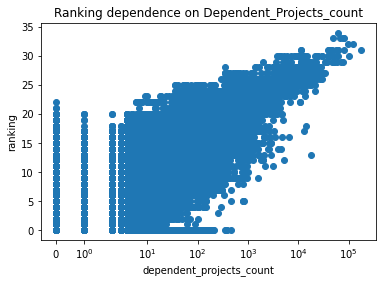

In [ ]:
plt.figure()
plt.scatter(dependent_prj["dependent_projects_count"], dependent_prj["sourcerank"])
plt.title("Ranking dependence on Dependent_Projects_count")
plt.xscale('symlog')
plt.xlabel("dependent_projects_count")
plt.ylabel("ranking")

***2) Dependent_repos_count relation with Ranking***

In [ ]:
%%bigquery --project $project_id dependent_repos

SELECT sourcerank,dependent_repositories_count FROM `bigquery-public-data.libraries_io.projects`

Text(0, 0.5, 'ranking')

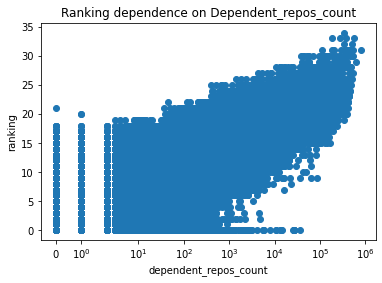

In [ ]:
plt.figure()
plt.scatter(dependent_repos["dependent_repositories_count"], dependent_repos["sourcerank"])
plt.title("Ranking dependence on Dependent_repos_count")
plt.xscale('symlog')
plt.xlabel("dependent_repos_count")
plt.ylabel("ranking")

---

*TODO: Exploring your questions, with appropriate visualizations*

---

***3) versions_count relation with Ranking***

In [ ]:
%%bigquery --project $project_id versions_count

SELECT sourcerank,versions_count FROM `bigquery-public-data.libraries_io.projects`

Text(0, 0.5, 'ranking')

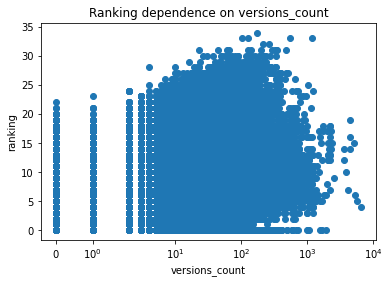

In [ ]:
plt.figure()
plt.scatter(versions_count["versions_count"], versions_count["sourcerank"])
plt.title("Ranking dependence on versions_count")
plt.xscale('symlog')
plt.xlabel("versions_count")
plt.ylabel("ranking")

***4) language relation with Ranking***

In [ ]:
%%bigquery --project $project_id language_rank

SELECT round(avg(sourcerank),1) as avg_rank,language FROM `bigquery-public-data.libraries_io.projects` group by language order by avg_rank desc limit 5

Text(0, 0.5, 'Average ranking')

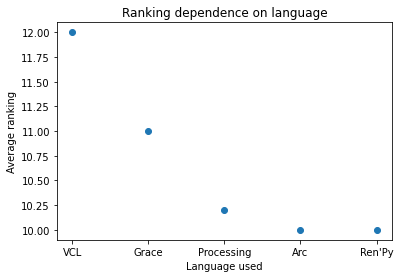

In [ ]:
plt.figure()
plt.scatter(language_rank["language"],language_rank["avg_rank"])
plt.title("Ranking dependence on language")
plt.xlabel("Language used")
plt.ylabel("Average ranking")

In [ ]:
%%bigquery --project $project_id

SELECT
  COUNT(*) AS projects_count,
  ROUND(AVG(sourcerank),1) AS avg_rank,
  LANGUAGE
FROM
  `bigquery-public-data.libraries_io.projects`
GROUP BY
  LANGUAGE
ORDER BY
  projects_count DESC
LIMIT
  10

,projects_count,avg_rank,LANGUAGE
0,990713,2.8,Go
1,896185,2.6,None
2,560635,5.8,JavaScript
3,217142,5.8,PHP
4,101450,6.1,Python
5,100939,7.0,Ruby
6,71116,7.1,Java
7,54967,4.4,TypeScript
8,51589,6.2,C#
9,32107,5.7,CSS


***5) status relation with Ranking***

In [ ]:
%%bigquery --project $project_id status

SELECT
  ROUND(AVG(sourcerank),2) avg_rank,
IF
  (status IS NULL,
    'active',
    status) AS status
FROM
  `bigquery-public-data.libraries_io.projects`
GROUP BY
  status
ORDER BY
  avg_rank DESC

Text(0, 0.5, 'Average ranking')

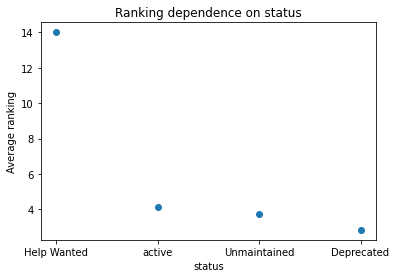

In [ ]:
plt.figure()
plt.scatter(status["status"], status["avg_rank"])
plt.title("Ranking dependence on status")
plt.xlabel("status")
plt.ylabel("Average ranking")

In [ ]:
%%bigquery --project $project_id

SELECT
  sourcerank,
  status
FROM
  `bigquery-public-data.libraries_io.projects`
WHERE
  status='Help Wanted'

,sourcerank,status
0,14,Help Wanted


**6) last_updated relation with Project Ranking**

In [ ]:
%%bigquery --project $project_id last_updated

SELECT
  sourcerank,
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), updated_timestamp, second) AS time_since_last_update
FROM
  `bigquery-public-data.libraries_io.projects`

Text(0, 0.5, 'Project ranking')

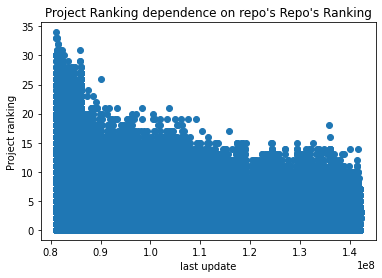

In [ ]:
plt.figure()
plt.scatter(last_updated["time_since_last_update"], last_updated["sourcerank"])
plt.title("Project Ranking dependence on time_since_last_updated")
plt.xlabel("last update")
plt.ylabel("Project ranking")

**7) last_synced_timestamp relation with Project Ranking**

In [ ]:
%%bigquery --project $project_id last_synced

SELECT
  sourcerank,
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), last_synced_timestamp, second) AS time_since_last_synced
FROM
  `bigquery-public-data.libraries_io.projects`

Text(0, 0.5, 'Project ranking')

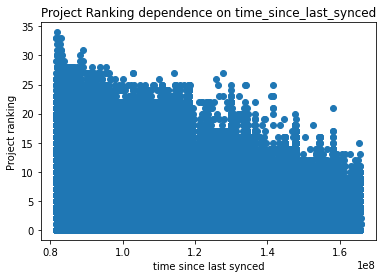

In [ ]:
plt.figure()
plt.scatter(last_synced["time_since_last_synced"], last_synced["sourcerank"])
plt.title("Project Ranking dependence on time_since_last_synced")
plt.xlabel("time since last synced")
plt.ylabel("Project ranking")

**8) latest_release_publish_timestamp relation with Project Ranking**

In [ ]:
%%bigquery --project $project_id last_released

SELECT
  sourcerank,
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), latest_release_publish_timestamp, second) AS time_since_last_release
FROM
  `bigquery-public-data.libraries_io.projects`

Text(0, 0.5, 'Project ranking')

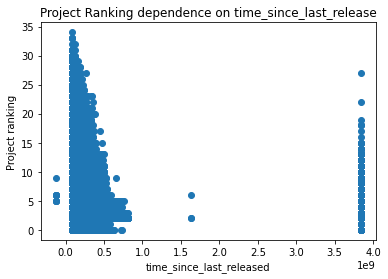

In [ ]:
plt.figure()
plt.scatter(last_released["time_since_last_release"], last_released["sourcerank"])
plt.title("Project Ranking dependence on time_since_last_release")
plt.xlabel("time_since_last_released")
plt.ylabel("Project ranking")

**9) keywords_length relation with Project Ranking**

In [ ]:
%%bigquery --project $project_id keywords_length

SELECT
  sourcerank,
  (LENGTH(keywords) - LENGTH(REPLACE(keywords,",","")) + 1) AS keywords_length
FROM
  `bigquery-public-data.libraries_io.projects`

Text(0, 0.5, 'Project ranking')

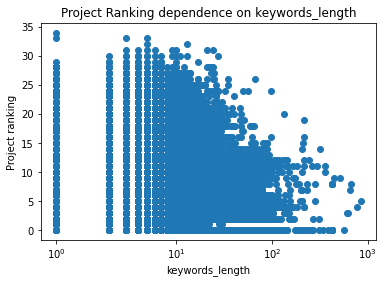

In [ ]:
plt.figure()
plt.scatter(keywords_length["keywords_length"], keywords_length["sourcerank"])
plt.title("Project Ranking dependence on keywords_length")
plt.xscale('symlog')
plt.xlabel("keywords_length")
plt.ylabel("Project ranking")

**10) description_length relation with Project Ranking**

In [ ]:
%%bigquery --project $project_id descrp_len

SELECT
  sourcerank,
  length(description) AS desc_len
FROM
  `bigquery-public-data.libraries_io.projects`

Text(0, 0.5, 'Project ranking')

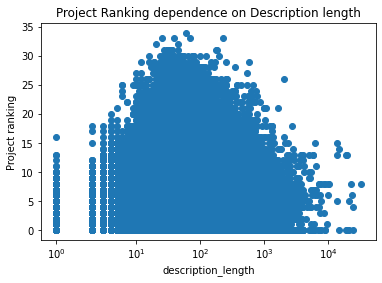

In [ ]:
plt.figure()
plt.scatter(descrp_len["desc_len"], descrp_len["sourcerank"])
plt.title("Project Ranking dependence on Description length")
plt.xscale('symlog')
plt.xlabel("description_length")
plt.ylabel("Project ranking")

***11) repo_stars_count relation with Project Ranking***

In [ ]:
%%bigquery --project $project_id repo_stars_count

SELECT
  repos.stars_count,
  prjcts.sourcerank
FROM
  `bigquery-public-data.libraries_io.projects` prjcts
JOIN
  `bigquery-public-data.libraries_io.repositories` repos
ON
  prjcts.repository_id=repos.id
ORDER BY
  sourcerank DESC

Text(0, 0.5, 'Project ranking')

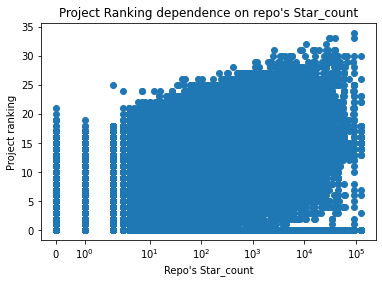

In [ ]:
plt.figure()
plt.scatter(repo_stars_count["stars_count"], repo_stars_count["sourcerank"])
plt.title("Project Ranking dependence on repo's Star_count")
plt.xscale('symlog')
plt.xlabel("Repo's Star_count")
plt.ylabel("Project ranking")

***12) repo_Ranking relation with Project Ranking***

In [ ]:
%%bigquery --project $project_id repo_Ranking

SELECT
  repos.sourcerank as repo_ranking,
  prjcts.sourcerank as prj_ranking
FROM
  `bigquery-public-data.libraries_io.projects` prjcts
JOIN
  `bigquery-public-data.libraries_io.repositories` repos
ON
  prjcts.repository_id=repos.id
ORDER BY
  prj_ranking DESC

Text(0, 0.5, 'Project ranking')

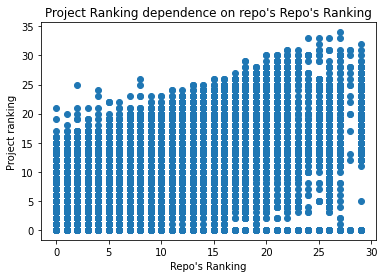

In [ ]:
plt.figure()
plt.scatter(repo_Ranking["repo_ranking"], repo_Ranking["prj_ranking"])
plt.title("Project Ranking dependence on repo's Repo's Ranking")
plt.xlabel("Repo's Ranking")
plt.ylabel("Project ranking")

***13) Repo Fork Count relation with Project Ranking***

In [ ]:
%%bigquery --project $project_id repo_fork_count

SELECT
  repos.forks_count as repo_forks_count,
  prjcts.sourcerank as prj_ranking
FROM
  `bigquery-public-data.libraries_io.projects` prjcts
JOIN
  `bigquery-public-data.libraries_io.repositories` repos
ON
  prjcts.repository_id=repos.id
ORDER BY
  prj_ranking DESC

Text(0, 0.5, 'Project ranking')

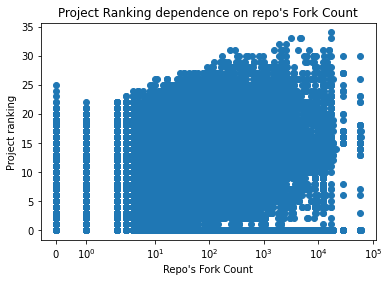

In [ ]:
plt.figure()
plt.scatter(repo_fork_count["repo_forks_count"], repo_fork_count["prj_ranking"])
plt.title("Project Ranking dependence on repo's Fork Count")
plt.xscale('symlog')
plt.xlabel("Repo's Fork Count")
plt.ylabel("Project ranking")

***14) Repo Watcher Count relation with Project Ranking***

In [ ]:
%%bigquery --project $project_id repo_watcher_count

SELECT
  repos.watchers_count as repo_watcher_count,
  prjcts.sourcerank as prj_ranking
FROM
  `bigquery-public-data.libraries_io.projects` prjcts
JOIN
  `bigquery-public-data.libraries_io.repositories` repos
ON
  prjcts.repository_id=repos.id
ORDER BY
  prj_ranking DESC

Text(0, 0.5, 'Project ranking')

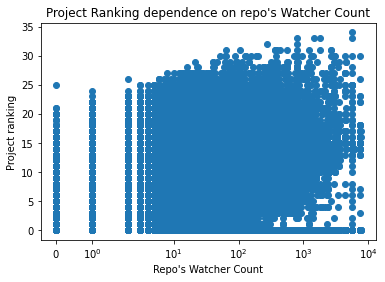

In [ ]:
plt.figure()
plt.scatter(repo_watcher_count["repo_watcher_count"], repo_watcher_count["prj_ranking"])
plt.title("Project Ranking dependence on repo's Watcher Count")
plt.xscale('symlog')
plt.xlabel("Repo's Watcher Count")
plt.ylabel("Project ranking")

***15) Repo Contributors Count relation with Project Ranking***

> Indented block



In [ ]:
%%bigquery --project $project_id repo_contrb_count

SELECT
  repos.contributors_count as repo_contributor_count,
  prjcts.sourcerank as prj_ranking
FROM
  `bigquery-public-data.libraries_io.projects` prjcts
JOIN
  `bigquery-public-data.libraries_io.repositories` repos
ON
  prjcts.repository_id=repos.id
ORDER BY
  prj_ranking DESC

Text(0, 0.5, 'Project ranking')

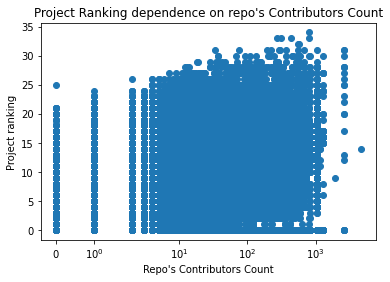

In [ ]:
plt.figure()
plt.scatter(repo_contrb_count["repo_contributor_count"], repo_contrb_count["prj_ranking"])
plt.title("Project Ranking dependence on repo's Contributors Count")
plt.xscale('symlog')
plt.xlabel("Repo's Contributors Count")
plt.ylabel("Project ranking")

***16) Repo Last Updated relation with Project Ranking***

In [ ]:
%%bigquery --project $project_id repo_last_updated

SELECT
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), repos.updated_timestamp, second) AS time_since_last_update_Repo,
  prjcts.sourcerank as prj_ranking
FROM
  `bigquery-public-data.libraries_io.projects` prjcts
JOIN
  `bigquery-public-data.libraries_io.repositories` repos
ON
  prjcts.repository_id=repos.id
ORDER BY
  prj_ranking DESC

Text(0, 0.5, 'Project ranking')

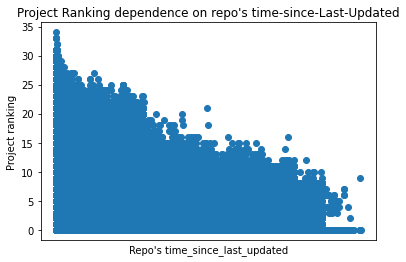

In [ ]:
plt.figure()
plt.scatter(repo_last_updated["time_since_last_update_Repo"], repo_last_updated["prj_ranking"])
plt.title("Project Ranking dependence on repo's time-since-Last-Updated")
plt.xscale('symlog')
plt.xlabel("Repo's time_since_last_updated")
plt.ylabel("Project ranking")

***17) Repo Last Synced relation with Project Ranking***

In [ ]:
%%bigquery --project $project_id repo_last_synced

SELECT
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), repos.last_synced_timestamp, second) AS time_since_last_synced,
  prjcts.sourcerank as prj_ranking
FROM
  `bigquery-public-data.libraries_io.projects` prjcts
JOIN
  `bigquery-public-data.libraries_io.repositories` repos
ON
  prjcts.repository_id=repos.id
ORDER BY
  prj_ranking DESC

Text(0, 0.5, 'Project ranking')

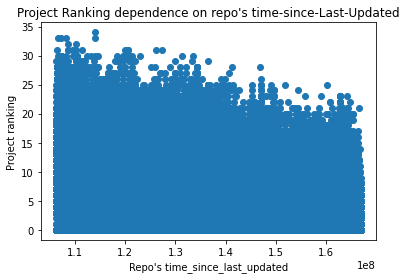

In [ ]:
plt.figure()
plt.scatter(repo_last_synced["time_since_last_synced"], repo_last_synced["prj_ranking"])
plt.title("Project Ranking dependence on repo's time-since-Last-Updated")
plt.xlabel("Repo's time_since_last_updated")
plt.ylabel("Project ranking")

***18) Repo Last pushed relation with Project Ranking***

In [ ]:
%%bigquery --project $project_id repo_last_pushed

SELECT
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), repos.last_pushed_timestamp, second) AS time_since_last_pushed_Repo,
  prjcts.sourcerank as prj_ranking
FROM
  `bigquery-public-data.libraries_io.projects` prjcts
JOIN
  `bigquery-public-data.libraries_io.repositories` repos
ON
  prjcts.repository_id=repos.id
ORDER BY
  prj_ranking DESC

Text(0, 0.5, 'Project ranking')

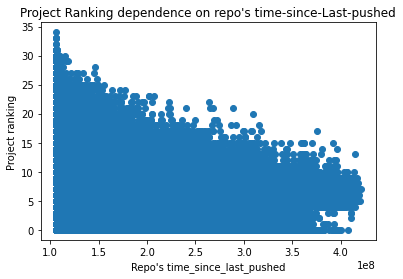

In [ ]:
plt.figure()
plt.scatter(repo_last_pushed["time_since_last_pushed_Repo"], repo_last_pushed["prj_ranking"])
plt.title("Project Ranking dependence on repo's time-since-Last-pushed")
plt.xlabel("Repo's time_since_last_pushed")
plt.ylabel("Project ranking")

***19) Repo Size relation with Project Ranking***

In [ ]:
%%bigquery --project $project_id repo_size

SELECT
  repos.size AS repo_size,
  prjcts.sourcerank as prj_ranking
FROM
  `bigquery-public-data.libraries_io.projects` prjcts
JOIN
  `bigquery-public-data.libraries_io.repositories` repos
ON
  prjcts.repository_id=repos.id
ORDER BY
  prj_ranking DESC

Text(0, 0.5, 'Project ranking')

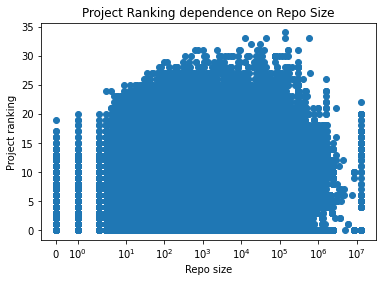

In [ ]:
plt.figure()
plt.scatter(repo_size["repo_size"], repo_size["prj_ranking"])
plt.title("Project Ranking dependence on Repo Size")
plt.xscale('symlog')
plt.xlabel("Repo size")
plt.ylabel("Project ranking")

***20) Repo status relation with Project Average Ranking***

In [ ]:
%%bigquery --project $project_id repo_status

SELECT
  ROUND(AVG(prjcts.sourcerank),2) avg_rank,
IF
  (repos.status='',
    'no status',
    repos.status) AS status
FROM
  `bigquery-public-data.libraries_io.projects` prjcts
JOIN
  `bigquery-public-data.libraries_io.repositories` repos
ON
  prjcts.repository_id=repos.id
  group by repos.status

Text(0, 0.5, 'Project Avg_ranking')

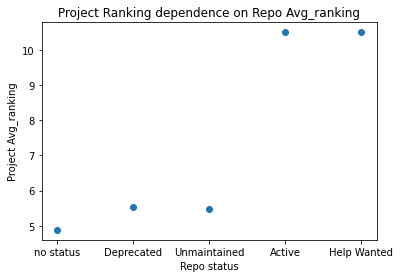

In [ ]:
plt.figure()
plt.scatter(repo_status["status"], repo_status["avg_rank"])
plt.title("Project Ranking dependence on Repo Avg_ranking")
plt.xlabel("Repo status")
plt.ylabel("Project Avg_ranking")

In [ ]:
%%bigquery --project $project_id

SELECT
  COUNT(status) row_count,
  status
FROM
  `bigquery-public-data.libraries_io.repositories`
GROUP BY
  status

,row_count,status
0,30702574,
1,1882,Unmaintained
2,1144,Deprecated
3,33,Active
4,1,Help Wanted


## Data Prediction

---

**Creating Datasets in bigquery**
---

In [ ]:
model_dataset_name = 'bqml_librariesIO'

dataset = bigquery.Dataset(client.dataset(model_dataset_name))
dataset.location = 'US'
client.create_dataset(dataset)

Dataset(DatasetReference('final-project-dtb', 'bqml_librariesIO'))

In [ ]:
model_dataset_name_for_LRmodel = 'bqml_librariesIO_LR'

dataset = bigquery.Dataset(client.dataset(model_dataset_name_for_LRmodel))
dataset.location = 'US'
client.create_dataset(dataset)

Dataset(DatasetReference('db-prj1', 'bqml_librariesIO_LR'))

**--> Training Data No.1(**with 7 features from projects table**)**

In [ ]:
SELECT
  sourcerank,
  dependent_projects_count,
  dependent_repositories_count,
  IF
  (status IS NULL,
    'active',
    status) AS status,
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), updated_timestamp, second) AS time_since_last_update,
  versions_count,
  LANGUAGE
FROM
  `bigquery-public-data.libraries_io.projects`
  where created_timestamp between '2015-01-11 23:56:18+00:00' and '2016-01-11 23:56:18+00:00'


**--> Training Data No.2(**with 7 features from projects table + 2 features from Repos table**)**

In [ ]:
SELECT
  prjct_data.sourcerank,
  dependent_projects_count,
  dependent_repositories_count,
  repo_data.repo_ranking,
  repo_stars,
  status,
  time_since_last_update,
  versions_count,
  language,
FROM (
  SELECT
    sourcerank,
    dependent_projects_count,
    dependent_repositories_count,
  IF
    (status IS NULL,
      'active',
      status) AS status,
    TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), updated_timestamp, second) AS time_since_last_update,
    versions_count,
    LANGUAGE,
    repository_id
  FROM
    `bigquery-public-data.libraries_io.projects`
  WHERE
    created_timestamp BETWEEN '2015-01-11 23:56:18+00:00'
    AND '2016-01-11 23:56:18+00:00') prjct_data
JOIN (
  SELECT
    repos.id,
    repos.sourcerank AS repo_ranking,
    repos.stars_count AS repo_stars
  FROM
    `bigquery-public-data.libraries_io.projects` prjcts
  JOIN
    `bigquery-public-data.libraries_io.repositories` repos
  ON
    prjcts.repository_id=repos.id) repo_data
ON
  prjct_data.repository_id=repo_data.id

**--> Training Data No.3(**with 9 features from projects table**)**

In [ ]:
SELECT
  sourcerank,
  dependent_projects_count,
  dependent_repositories_count,
  IF
  (status IS NULL,
    'active',
    status) AS status,
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), updated_timestamp, second) AS time_since_last_update,
  versions_count,
  LANGUAGE,
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), latest_release_publish_timestamp, second) AS time_since_last_release,
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), last_synced_timestamp, second) AS time_since_last_synced
FROM
  `bigquery-public-data.libraries_io.projects`
  where created_timestamp between '2015-01-11 23:56:18+00:00' and '2016-01-11 23:56:18+00:00'


**--> Training Data No.4 (**with 9 features from projects table + 2 features from Repos table**)**

In [ ]:
SELECT
  prjct_data.sourcerank,
  dependent_projects_count,
  dependent_repositories_count,
  repo_data.repo_ranking,
  repo_stars,
  status,
  time_since_last_update,
  versions_count,
  LANGUAGE,
  time_since_last_release,
  time_since_last_synced
FROM (
  SELECT
    sourcerank,
    dependent_projects_count,
    dependent_repositories_count,
  IF
    (status IS NULL,
      'active',
      status) AS status,
    TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), updated_timestamp, second) AS time_since_last_update,
    versions_count,
    LANGUAGE,
    TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), latest_release_publish_timestamp, second) AS time_since_last_release,
    TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), last_synced_timestamp, second) AS time_since_last_synced,
    repository_id
  FROM
    `bigquery-public-data.libraries_io.projects`
  WHERE
    created_timestamp BETWEEN '2015-01-11 23:56:18+00:00'
    AND '2015-01-25 23:56:18+00:00') prjct_data
JOIN (
  SELECT
    repos.id,
    repos.sourcerank AS repo_ranking,
    repos.stars_count AS repo_stars
  FROM
    `bigquery-public-data.libraries_io.projects` prjcts
  JOIN
    `bigquery-public-data.libraries_io.repositories` repos
  ON
    prjcts.repository_id=repos.id) repo_data
ON
  prjct_data.repository_id=repo_data.id

**--> Training Data No.5 (**changing 2 Repo features from Training data No.4**)**

In [ ]:
SELECT
  prjct_data.sourcerank,
  dependent_projects_count,
  dependent_repositories_count,
  status,
  time_since_last_update,
  versions_count,
  LANGUAGE,
  time_since_last_release,
  time_since_last_synced,
  time_since_last_pushed_Repo,
  time_since_last_synced_Repo
FROM (
  SELECT
    sourcerank,
    dependent_projects_count,
    dependent_repositories_count,
  IF
    (status IS NULL,
      'active',
      status) AS status,
    TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), updated_timestamp, second) AS time_since_last_update,
    versions_count,
    LANGUAGE,
    TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), latest_release_publish_timestamp, second) AS time_since_last_release,
    TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), last_synced_timestamp, second) AS time_since_last_synced,
    repository_id
  FROM
    `bigquery-public-data.libraries_io.projects`
  WHERE
    created_timestamp BETWEEN '2015-01-11 23:56:18+00:00'
    AND '2015-01-25 23:56:18+00:00') prjct_data
JOIN (
  SELECT
    repos.id,
    TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), repos.last_pushed_timestamp, second) AS time_since_last_pushed_Repo,
    TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), repos.last_synced_timestamp, second) AS time_since_last_synced_Repo,
  FROM
    `bigquery-public-data.libraries_io.projects` prjcts
  JOIN
    `bigquery-public-data.libraries_io.repositories` repos
  ON
    prjcts.repository_id=repos.id) repo_data
ON
  prjct_data.repository_id=repo_data.id

**--> Training Data No.6 (**with 9 features from projects table + 4 features from Repos table**)**

In [ ]:
SELECT
  prjct_data.sourcerank,
  dependent_projects_count,
  dependent_repositories_count,
  status,
  time_since_last_update,
  versions_count,
  LANGUAGE,
  time_since_last_release,
  time_since_last_synced,
  time_since_last_pushed_Repo,
  time_since_last_synced_Repo,
  repo_rank,
  repo_star_count
FROM (
  SELECT
    sourcerank,
    dependent_projects_count,
    dependent_repositories_count,
  IF
    (status IS NULL,
      'active',
      status) AS status,
    TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), updated_timestamp, second) AS time_since_last_update,
    versions_count,
    LANGUAGE,
    TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), latest_release_publish_timestamp, second) AS time_since_last_release,
    TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), last_synced_timestamp, second) AS time_since_last_synced,
    repository_id
  FROM
    `bigquery-public-data.libraries_io.projects`
  WHERE
    created_timestamp BETWEEN '2015-01-11 23:56:18+00:00'
    AND '2015-01-25 23:56:18+00:00') prjct_data
JOIN (
  SELECT
    repos.id,
    repos.sourcerank as repo_rank,
    repos.stars_count as repo_star_count,
    TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), repos.last_pushed_timestamp, second) AS time_since_last_pushed_Repo,
    TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), repos.last_synced_timestamp, second) AS time_since_last_synced_Repo,
  FROM
    `bigquery-public-data.libraries_io.projects` prjcts
  JOIN
    `bigquery-public-data.libraries_io.repositories` repos
  ON
    prjcts.repository_id=repos.id) repo_data
ON
  prjct_data.repository_id=repo_data.id
  WHERE
  time_since_last_pushed_Repo IS not NULL
  and time_since_last_synced_Repo IS not NULL
  and repo_star_count is not null
  and LANGUAGE IS not NULL
  and time_since_last_synced IS not NULL

**--> Training Data No.7 (**with 11 features from projects table**)**

In [ ]:
SELECT
  sourcerank,
  dependent_projects_count,
  dependent_repositories_count,
  IF
  (status IS NULL,
    'active',
    status) AS status,
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), updated_timestamp, second) AS time_since_last_update,
  versions_count,
  LANGUAGE,
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), latest_release_publish_timestamp, second) AS time_since_last_release,
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), last_synced_timestamp, second) AS time_since_last_synced,
  (LENGTH(keywords) - LENGTH(REPLACE(keywords,",","")) + 1) AS keywords_length,
  length(description) as descrp_len
FROM
  `bigquery-public-data.libraries_io.projects`
  where created_timestamp between '2015-01-11 23:56:18+00:00' and '2016-01-26 23:56:18+00:00'

***--> Splitting of Data***

In [ ]:
%%bigquery --project $project_id

SELECT
  min(created_timestamp) minim,
  max(created_timestamp) maxim
FROM
  `bigquery-public-data.libraries_io.projects`

,minim,maxim
0,2015-01-11 23:56:18+00:00,2018-12-22 20:18:27+00:00


**Large sets of Data:**

In [ ]:
%%bigquery --project $project_id

SELECT
  count(*) count_2015to2016
FROM
  `bigquery-public-data.libraries_io.projects`
  where created_timestamp between '2015-01-11 23:56:18+00:00' and '2016-01-11 23:56:18+00:00'
   

,count_2015to2016
0,1089327


In [ ]:
%%bigquery --project $project_id


SELECT
  count(*) count_2016to2017
FROM
  `bigquery-public-data.libraries_io.projects`
  where created_timestamp > '2016-01-11 23:56:18+00:00'  and created_timestamp <= '2017-01-11 23:56:18+00:00'
   

,count_2016to2017
0,913392


In [ ]:
%%bigquery --project $project_id


SELECT
  count(*) count_2017to2018
FROM
  `bigquery-public-data.libraries_io.projects`
  where created_timestamp > '2017-01-11 23:56:18+00:00'  and created_timestamp <= '2018-01-11 23:56:18+00:00'
   

,count_2017to2018
0,466015


In [ ]:
%%bigquery --project $project_id

SELECT
  count(*) count_2018toEND
FROM
  `bigquery-public-data.libraries_io.projects`
  where created_timestamp > '2018-01-11 23:56:18+00:00'

,count_2018toEND
0,865192


**Small sets of Data:**

In [ ]:
%%bigquery --project $project_id

SELECT
  count(*) jan11_to_jan25_trainSet
FROM
  `bigquery-public-data.libraries_io.projects`
  where created_timestamp between '2015-01-11 23:56:18+00:00' and '2015-01-25 23:56:18+00:00'

,jan11_to_jan25_trainSet
0,116740


In [ ]:
%%bigquery --project $project_id

SELECT
  count(*) jan26_jan27_evalSet
FROM
  `bigquery-public-data.libraries_io.projects`
  where created_timestamp between '2015-01-26 23:56:18+00:00' and '2015-01-27 15:56:18+00:00'

,jan26_jan27_evalSet
0,20120


In [ ]:
%%bigquery --project $project_id

SELECT
  count(*) jan27_jan28_testSet
FROM
  `bigquery-public-data.libraries_io.projects`
  where created_timestamp between '2015-01-27 15:56:18+00:00' and '2015-01-28 00:56:18+00:00'

,jan27_jan28_testSet
0,19864


In [ ]:
%%bigquery --project $project_id

SELECT
  count(*) as jan28_jan29_predictionSet
FROM
  `bigquery-public-data.libraries_io.projects`
  where created_timestamp between '2015-01-28 23:56:18+00:00' and '2015-01-29 02:56:18+00:00'


,jan28_jan29_predictionSet
0,17317


**Model creation by using 'Linear Regression' on Training data No.1 with large set of data (**2015-2016 data**)**

---



In [ ]:
%%bigquery --project $project_id

CREATE OR REPLACE MODEL `bqml_librariesIO.rank_predictor_model`
OPTIONS(model_type='linear_reg',input_label_cols=['sourcerank']) as
SELECT
  sourcerank,
  dependent_projects_count,
  dependent_repositories_count,
  IF
  (status IS NULL,
    'active',
    status) AS status,
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), updated_timestamp, second) AS time_since_last_update,
  versions_count,
  LANGUAGE
FROM
  `bigquery-public-data.libraries_io.projects`
  where created_timestamp between '2015-01-11 23:56:18+00:00' and '2016-01-11 23:56:18+00:00'

""


In [ ]:
%%bigquery --project $project_id

SELECT
  *
FROM
  ML.EVALUATE(MODEL `bqml_librariesIO.rank_predictor_model`, (
SELECT
  sourcerank,
  dependent_projects_count,
  dependent_repositories_count,
  IF
  (status IS NULL,
    'active',
    status) AS status,
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), updated_timestamp, second) AS time_since_last_update,
  versions_count,
  LANGUAGE
FROM
  `bigquery-public-data.libraries_io.projects`
  where created_timestamp > '2016-01-11 23:56:18+00:00'  and created_timestamp <= '2017-01-11 23:56:18+00:00'))

,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,1.896504,6.354987,0.353378,1.527391,0.233646,0.260111


**Model creation by using 'Logistic Regression' on Training data No.1 with large set of data (**2015-2016 data**)**

---



In [ ]:
%%bigquery --project $project_id

CREATE OR REPLACE MODEL `bqml_librariesIO.rank_predictor_model`
OPTIONS(model_type='logistic_reg',input_label_cols=['sourcerank']) as
SELECT
  sourcerank,
  dependent_projects_count,
  dependent_repositories_count,
  IF
  (status IS NULL,
    'active',
    status) AS status,
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), updated_timestamp, second) AS time_since_last_update,
  versions_count,
  LANGUAGE
FROM
  `bigquery-public-data.libraries_io.projects`
  where created_timestamp between '2015-01-11 23:56:18+00:00' and '2016-01-11 23:56:18+00:00'


""


In [ ]:
%%bigquery --project $project_id

SELECT
  *
FROM
  ML.EVALUATE(MODEL `bqml_librariesIO.rank_predictor_model`, (
SELECT
  sourcerank,
  dependent_projects_count,
  dependent_repositories_count,
  IF
  (status IS NULL,
    'active',
    status) AS status,
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), updated_timestamp, second) AS time_since_last_update,
  versions_count,
  LANGUAGE
FROM
  `bigquery-public-data.libraries_io.projects`
  where created_timestamp > '2016-01-11 23:56:18+00:00'  and created_timestamp <= '2017-01-11 23:56:18+00:00'))

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.069769,0.053023,0.185529,0.043299,3.98761,0.771809


**Doing same as above with small set of data(jan11-jan25):**

In [ ]:
%%bigquery --project $project_id

CREATE OR REPLACE MODEL `bqml_librariesIO.rank_predictor_model`
OPTIONS(model_type='logistic_reg',input_label_cols=['sourcerank']) as
SELECT
  sourcerank,
  dependent_projects_count,
  dependent_repositories_count,
  IF
  (status IS NULL,
    'active',
    status) AS status,
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), updated_timestamp, second) AS time_since_last_update,
  versions_count,
  LANGUAGE
FROM
  `bigquery-public-data.libraries_io.projects`
  where created_timestamp between '2015-01-11 23:56:18+00:00' and '2015-01-25 23:56:18+00:00'


""


In [ ]:
%%bigquery --project $project_id

SELECT
  *
FROM
  ML.EVALUATE(MODEL `bqml_librariesIO.rank_predictor_model`, (
SELECT
  sourcerank,
  dependent_projects_count,
  dependent_repositories_count,
  IF
  (status IS NULL,
    'active',
    status) AS status,
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), updated_timestamp, second) AS time_since_last_update,
  versions_count,
  LANGUAGE
FROM
  `bigquery-public-data.libraries_io.projects`
  where created_timestamp between '2015-01-26 23:56:18+00:00' and '2015-01-27 15:56:18+00:00'))

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.066607,0.092453,0.174801,0.037734,3.741339,0.809725


**-->Model creation by using 'Logistic Regression' on Training data No.2 with small set of data(jan11-jan25)**

In [ ]:
%%bigquery --project $project_id

CREATE OR REPLACE MODEL `bqml_librariesIO_LR.rank_predictor_model`
OPTIONS(model_type='logistic_reg', auto_class_weights=TRUE,input_label_cols=['sourcerank']) as
SELECT
  distinct
  prjct_data.sourcerank,
  dependent_projects_count,
  dependent_repositories_count,
  repo_data.repo_ranking,
  repo_stars,
  status,
  time_since_last_update,
  versions_count,
  language,
FROM (
  SELECT
    sourcerank,
    dependent_projects_count,
    dependent_repositories_count,
  IF
    (status IS NULL,
      'active',
      status) AS status,
    TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), updated_timestamp, second) AS time_since_last_update,
    versions_count,
    LANGUAGE,
    repository_id
  FROM
    `bigquery-public-data.libraries_io.projects`
  WHERE
 created_timestamp between '2015-01-11 23:56:18+00:00' and '2015-01-25 23:56:18+00:00') prjct_data
JOIN (
  SELECT
    repos.id,
    repos.sourcerank AS repo_ranking,
    repos.stars_count AS repo_stars
  FROM
    `bigquery-public-data.libraries_io.projects` prjcts
  JOIN
    `bigquery-public-data.libraries_io.repositories` repos
  ON
    prjcts.repository_id=repos.id) repo_data
ON
  prjct_data.repository_id=repo_data.id

""


In [ ]:
%%bigquery --project $project_id

SELECT
  *
FROM
  ML.EVALUATE(MODEL `bqml_librariesIO_LR.rank_predictor_model`, (
SELECT
  prjct_data.sourcerank,
  dependent_projects_count,
  dependent_repositories_count,
  repo_data.repo_ranking,
  repo_stars,
  status,
  time_since_last_update,
  versions_count,
  language,
FROM (
  SELECT
    sourcerank,
    dependent_projects_count,
    dependent_repositories_count,
  IF
    (status IS NULL,
      'active',
      status) AS status,
    TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), updated_timestamp, second) AS time_since_last_update,
    versions_count,
    LANGUAGE,
    repository_id
  FROM
    `bigquery-public-data.libraries_io.projects`
  WHERE
 created_timestamp between '2015-01-26 23:56:18+00:00' and '2015-01-27 15:56:18+00:00') prjct_data
JOIN (
  SELECT
    repos.id,
    repos.sourcerank AS repo_ranking,
    repos.stars_count AS repo_stars
  FROM
    `bigquery-public-data.libraries_io.projects` prjcts
  JOIN
    `bigquery-public-data.libraries_io.repositories` repos
  ON
    prjcts.repository_id=repos.id) repo_data
ON
  prjct_data.repository_id=repo_data.id))

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.042714,0.049417,0.003533,0.004152,3.697269,0.470065


**Doing same as above with 'Language' feature dropped:**

In [ ]:
%%bigquery --project $project_id

CREATE OR REPLACE MODEL `bqml_librariesIO.rank_predictor_model`
OPTIONS(model_type='logistic_reg', auto_class_weights=TRUE,input_label_cols=['sourcerank']) as
SELECT
  prjct_data.sourcerank,
  dependent_projects_count,
  dependent_repositories_count,
  repo_data.repo_ranking,
  repo_stars,
  status,
  time_since_last_update,
  versions_count,
FROM (
  SELECT
    sourcerank,
    dependent_projects_count,
    dependent_repositories_count,
  IF
    (status IS NULL,
      'active',
      status) AS status,
    TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), updated_timestamp, second) AS time_since_last_update,
    versions_count,
    repository_id
  FROM
    `bigquery-public-data.libraries_io.projects`
  WHERE
 created_timestamp between '2015-01-11 23:56:18+00:00' and '2015-01-25 23:56:18+00:00') prjct_data
JOIN (
  SELECT
    repos.id,
    repos.sourcerank AS repo_ranking,
    repos.stars_count AS repo_stars
  FROM
    `bigquery-public-data.libraries_io.projects` prjcts
  JOIN
    `bigquery-public-data.libraries_io.repositories` repos
  ON
    prjcts.repository_id=repos.id) repo_data
ON
  prjct_data.repository_id=repo_data.id

""


In [ ]:
%%bigquery --project $project_id

SELECT
  *
FROM
  ML.EVALUATE(MODEL `bqml_librariesIO.rank_predictor_model`, (
SELECT
  prjct_data.sourcerank,
  dependent_projects_count,
  dependent_repositories_count,
  repo_data.repo_ranking,
  repo_stars,
  status,
  time_since_last_update,
  versions_count,
FROM (
  SELECT
    sourcerank,
    dependent_projects_count,
    dependent_repositories_count,
  IF
    (status IS NULL,
      'active',
      status) AS status,
    TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), updated_timestamp, second) AS time_since_last_update,
    versions_count,
    repository_id
  FROM
    `bigquery-public-data.libraries_io.projects`
  WHERE
 created_timestamp between '2015-01-26 23:56:18+00:00' and '2015-01-27 15:56:18+00:00') prjct_data
JOIN (
  SELECT
    repos.id,
    repos.sourcerank AS repo_ranking,
    repos.stars_count AS repo_stars
  FROM
    `bigquery-public-data.libraries_io.projects` prjcts
  JOIN
    `bigquery-public-data.libraries_io.repositories` repos
  ON
    prjcts.repository_id=repos.id) repo_data
ON
  prjct_data.repository_id=repo_data.id))

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.017248,0.034492,0.003003,0.008567,8.971957,0.512339


**Analyzing Weights used by model(**which lead to dropping 'status' feature**):**

In [ ]:
%%bigquery --project $project_id

SELECT
  *
FROM
  ML.WEIGHTS(MODEL `bqml_librariesIO.rank_predictor_model`)
  where processed_input='dependent_projects_count' order by class_label

,class_label,processed_input,weight,category_weights
0,0,dependent_projects_count,-0.000102,[]
1,1,dependent_projects_count,-0.000102,[]
2,2,dependent_projects_count,-0.000102,[]
3,3,dependent_projects_count,-0.000102,[]
4,4,dependent_projects_count,-0.000102,[]
5,5,dependent_projects_count,-0.000102,[]
6,6,dependent_projects_count,-0.000102,[]
7,7,dependent_projects_count,-0.000102,[]
8,8,dependent_projects_count,-0.000102,[]
9,9,dependent_projects_count,-0.000103,[]


In [ ]:
%%bigquery --project $project_id

SELECT
  *
FROM
  ML.WEIGHTS(MODEL `bqml_librariesIO.rank_predictor_model`)
  where processed_input='dependent_repositories_count' order by class_label

,class_label,processed_input,weight,category_weights
0,0,dependent_repositories_count,-2.419188e-06,[]
1,1,dependent_repositories_count,-2.422447e-06,[]
2,2,dependent_repositories_count,-2.422850e-06,[]
3,3,dependent_repositories_count,-2.424419e-06,[]
4,4,dependent_repositories_count,-2.423165e-06,[]
5,5,dependent_repositories_count,-2.423082e-06,[]
6,6,dependent_repositories_count,-2.424188e-06,[]
7,7,dependent_repositories_count,-2.424119e-06,[]
8,8,dependent_repositories_count,-2.424891e-06,[]
9,9,dependent_repositories_count,-2.429556e-06,[]


In [ ]:
%%bigquery --project $project_id

SELECT
  *
FROM
  ML.WEIGHTS(MODEL `bqml_librariesIO.rank_predictor_model`)
  where processed_input='repo_ranking' order by class_label

,class_label,processed_input,weight,category_weights
0,0,repo_ranking,-0.004341,[]
1,1,repo_ranking,-0.004096,[]
2,2,repo_ranking,-0.003912,[]
3,3,repo_ranking,-0.003418,[]
4,4,repo_ranking,-0.003986,[]
5,5,repo_ranking,-0.003940,[]
6,6,repo_ranking,-0.003785,[]
7,7,repo_ranking,-0.003699,[]
8,8,repo_ranking,-0.003361,[]
9,9,repo_ranking,-0.001309,[]


In [ ]:
%%bigquery --project $project_id

SELECT
  *
FROM
  ML.WEIGHTS(MODEL `bqml_librariesIO.rank_predictor_model`)
  where processed_input='repo_stars' order by class_label

,class_label,processed_input,weight,category_weights
0,0,repo_stars,-1.420533e-06,[]
1,1,repo_stars,-1.433534e-06,[]
2,2,repo_stars,-1.435333e-06,[]
3,3,repo_stars,-1.385598e-06,[]
4,4,repo_stars,-1.350734e-06,[]
5,5,repo_stars,-1.427527e-06,[]
6,6,repo_stars,-1.333909e-06,[]
7,7,repo_stars,-1.433741e-06,[]
8,8,repo_stars,-1.434513e-06,[]
9,9,repo_stars,-1.436212e-06,[]


In [ ]:
%%bigquery --project $project_id

SELECT
  *
FROM
  ML.WEIGHTS(MODEL `bqml_librariesIO.rank_predictor_model`)
  where processed_input='status' order by class_label

,class_label,processed_input,weight,category_weights
0,0,status,None,"[{'category': 'active', 'weight': -0.012672597..."
1,1,status,None,"[{'category': 'active', 'weight': 0.0017485947..."
2,2,status,None,"[{'category': 'active', 'weight': 0.0024944577..."
3,3,status,None,"[{'category': 'active', 'weight': 0.0024965191..."
4,4,status,None,"[{'category': 'active', 'weight': 0.0029334557..."
5,5,status,None,"[{'category': 'active', 'weight': 0.0033094081..."
6,6,status,None,"[{'category': 'active', 'weight': 0.0033088099..."
7,7,status,None,"[{'category': 'active', 'weight': 0.0033650293..."
8,8,status,None,"[{'category': 'active', 'weight': 0.0033620579..."
9,9,status,None,"[{'category': 'active', 'weight': 0.0033435839..."


In [ ]:
%%bigquery --project $project_id

SELECT
  *
FROM
  ML.WEIGHTS(MODEL `bqml_librariesIO.rank_predictor_model`)
  where processed_input='time_since_last_update' order by class_label

,class_label,processed_input,weight,category_weights
0,0,time_since_last_update,3.213269e-09,[]
1,1,time_since_last_update,3.268197e-09,[]
2,2,time_since_last_update,3.324233e-09,[]
3,3,time_since_last_update,1.324313e-09,[]
4,4,time_since_last_update,3.236354e-09,[]
5,5,time_since_last_update,2.947167e-09,[]
6,6,time_since_last_update,1.972222e-09,[]
7,7,time_since_last_update,1.148648e-09,[]
8,8,time_since_last_update,8.393210e-10,[]
9,9,time_since_last_update,-1.461767e-09,[]


In [ ]:
%%bigquery --project $project_id

SELECT
  *
FROM
  ML.WEIGHTS(MODEL `bqml_librariesIO.rank_predictor_model`)
  where processed_input='versions_count' order_by class_label

,class_label,processed_input,weight,category_weights
0,0,versions_count,-0.000452,[]
1,1,versions_count,-0.000449,[]
2,2,versions_count,-0.000451,[]
3,3,versions_count,-0.000447,[]
4,4,versions_count,-0.000448,[]
5,5,versions_count,-0.000447,[]
6,6,versions_count,-0.000426,[]
7,7,versions_count,-0.000417,[]
8,8,versions_count,-0.000406,[]
9,9,versions_count,-0.000372,[]


**Doing same as above model with 'status' feature dropped now:**

In [ ]:
%%bigquery --project $project_id

CREATE OR REPLACE MODEL `bqml_librariesIO.rank_predictor_model`
OPTIONS(model_type='logistic_reg', auto_class_weights=TRUE,input_label_cols=['sourcerank']) as
SELECT
  prjct_data.sourcerank,
  dependent_projects_count,
  dependent_repositories_count,
  repo_data.repo_ranking,
  repo_stars,
  time_since_last_update,
  versions_count,
FROM (
  SELECT
    sourcerank,
    dependent_projects_count,
    dependent_repositories_count,
    TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), updated_timestamp, second) AS time_since_last_update,
    versions_count,
    repository_id
  FROM
    `bigquery-public-data.libraries_io.projects`
  WHERE
 created_timestamp between '2015-01-11 23:56:18+00:00' and '2015-01-25 23:56:18+00:00') prjct_data
JOIN (
  SELECT
    repos.id,
    repos.sourcerank AS repo_ranking,
    repos.stars_count AS repo_stars
  FROM
    `bigquery-public-data.libraries_io.projects` prjcts
  JOIN
    `bigquery-public-data.libraries_io.repositories` repos
  ON
    prjcts.repository_id=repos.id) repo_data
ON
  prjct_data.repository_id=repo_data.id

""


In [ ]:
%%bigquery --project $project_id

SELECT
  *
FROM
  ML.EVALUATE(MODEL `bqml_librariesIO.rank_predictor_model`, (
SELECT
  prjct_data.sourcerank,
  dependent_projects_count,
  dependent_repositories_count,
  repo_data.repo_ranking,
  repo_stars,
  time_since_last_update,
  versions_count,
FROM (
  SELECT
    sourcerank,
    dependent_projects_count,
    dependent_repositories_count,
    TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), updated_timestamp, second) AS time_since_last_update,
    versions_count,
    repository_id
  FROM
    `bigquery-public-data.libraries_io.projects`
  WHERE
 created_timestamp between '2015-01-26 23:56:18+00:00' and '2015-01-27 15:56:18+00:00') prjct_data
JOIN (
  SELECT
    repos.id,
    repos.sourcerank AS repo_ranking,
    repos.stars_count AS repo_stars
  FROM
    `bigquery-public-data.libraries_io.projects` prjcts
  JOIN
    `bigquery-public-data.libraries_io.repositories` repos
  ON
    prjcts.repository_id=repos.id) repo_data
ON
  prjct_data.repository_id=repo_data.id))

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.006634,0.032267,0.002751,0.004575,5.712664,0.524959


**-->Model creation by using 'Logistic Regression' on Training data No.3 with small set of data(jan11-jan25)**

In [ ]:
%%bigquery --project $project_id

CREATE OR REPLACE MODEL `bqml_librariesIO.rank_predictor_model`
OPTIONS(model_type='logistic_reg',input_label_cols=['sourcerank']) as
SELECT
  sourcerank,
  dependent_projects_count,
  dependent_repositories_count,
  IF
  (status IS NULL,
    'active',
    status) AS status,
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), updated_timestamp, second) AS time_since_last_update,
  versions_count,
  LANGUAGE,
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), latest_release_publish_timestamp, second) AS time_since_last_release,
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), last_synced_timestamp, second) AS time_since_last_synced
FROM
  `bigquery-public-data.libraries_io.projects`
  where created_timestamp between '2015-01-11 23:56:18+00:00' and '2015-01-25 23:56:18+00:00'


""


In [ ]:
%%bigquery --project $project_id

SELECT
  *
FROM
  ML.EVALUATE(MODEL `bqml_librariesIO.rank_predictor_model`, (
SELECT
  sourcerank,
  dependent_projects_count,
  dependent_repositories_count,
  IF
  (status IS NULL,
    'active',
    status) AS status,
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), updated_timestamp, second) AS time_since_last_update,
  versions_count,
  LANGUAGE,
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), latest_release_publish_timestamp, second) AS time_since_last_release,
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), last_synced_timestamp, second) AS time_since_last_synced
FROM
  `bigquery-public-data.libraries_io.projects`
  where created_timestamp between '2015-01-26 23:56:18+00:00' and '2015-01-27 15:56:18+00:00'))

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.065689,0.086017,0.252535,0.051396,3.552886,0.816146


**-->Doing same as above after removing NULLs**

In [ ]:
%%bigquery --project $project_id

CREATE OR REPLACE MODEL `bqml_librariesIO.rank_predictor_model`
OPTIONS(model_type='logistic_reg',input_label_cols=['sourcerank']) as
SELECT
  sourcerank,
  dependent_projects_count,
  dependent_repositories_count,
  IF
  (status IS NULL,
    'active',
    status) AS status,
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), updated_timestamp, second) AS time_since_last_update,
  versions_count,
  LANGUAGE,
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), latest_release_publish_timestamp, second) AS time_since_last_release,
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), last_synced_timestamp, second) AS time_since_last_synced
FROM
  `bigquery-public-data.libraries_io.projects`
  where created_timestamp between '2015-01-11 23:56:18+00:00' and '2015-01-25 23:56:18+00:00'
  and
  LANGUAGE IS NOT NULL
    AND last_synced_timestamp IS NOT NULL


""


In [ ]:
%%bigquery --project $project_id

SELECT
  *
FROM
  ML.EVALUATE(MODEL `bqml_librariesIO.rank_predictor_model`, (
SELECT
  sourcerank,
  dependent_projects_count,
  dependent_repositories_count,
  IF
  (status IS NULL,
    'active',
    status) AS status,
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), updated_timestamp, second) AS time_since_last_update,
  versions_count,
  LANGUAGE,
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), latest_release_publish_timestamp, second) AS time_since_last_release,
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), last_synced_timestamp, second) AS time_since_last_synced
FROM
  `bigquery-public-data.libraries_io.projects`
  where created_timestamp between '2015-01-26 23:56:18+00:00' and '2015-01-27 15:56:18+00:00'
   and LANGUAGE IS NOT NULL
    AND last_synced_timestamp IS NOT NULL))

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.03779,0.075947,0.248677,0.035217,3.634602,0.777773


**-->Model creation by using 'Logistic Regression' on Training data No.2 with small set of data(jan11-jan25)**

In [ ]:
%%bigquery --project $project_id

CREATE OR REPLACE MODEL `bqml_librariesIO_LR.rank_predictor_model`
OPTIONS(model_type='logistic_reg', auto_class_weights=TRUE,input_label_cols=['sourcerank']) as
SELECT
  prjct_data.sourcerank,
  dependent_projects_count,
  dependent_repositories_count,
  repo_data.repo_ranking,
  repo_stars,
  status,
  time_since_last_update,
  versions_count,
  LANGUAGE,
  time_since_last_release,
  time_since_last_synced
FROM (
  SELECT
    sourcerank,
    dependent_projects_count,
    dependent_repositories_count,
  IF
    (status IS NULL,
      'active',
      status) AS status,
    TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), updated_timestamp, second) AS time_since_last_update,
    versions_count,
    LANGUAGE,
    TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), latest_release_publish_timestamp, second) AS time_since_last_release,
    TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), last_synced_timestamp, second) AS time_since_last_synced,
    repository_id
  FROM
    `bigquery-public-data.libraries_io.projects`
  WHERE
    created_timestamp BETWEEN '2015-01-11 23:56:18+00:00'
    AND '2015-01-25 23:56:18+00:00') prjct_data
JOIN (
  SELECT
    repos.id,
    repos.sourcerank AS repo_ranking,
    repos.stars_count AS repo_stars
  FROM
    `bigquery-public-data.libraries_io.projects` prjcts
  JOIN
    `bigquery-public-data.libraries_io.repositories` repos
  ON
    prjcts.repository_id=repos.id) repo_data
ON
  prjct_data.repository_id=repo_data.id

""


-- Nulls is not reason for accuracy below:

In [ ]:
%%bigquery --project $project_id

SELECT
  *
FROM
  ML.EVALUATE(MODEL `bqml_librariesIO_LR.rank_predictor_model`, (
SELECT
  prjct_data.sourcerank,
  dependent_projects_count,
  dependent_repositories_count,
  repo_data.repo_ranking,
  repo_stars,
  status,
  time_since_last_update,
  versions_count,
  LANGUAGE,
  time_since_last_release,
  time_since_last_synced
FROM (
  SELECT
    sourcerank,
    dependent_projects_count,
    dependent_repositories_count,
  IF
    (status IS NULL,
      'active',
      status) AS status,
    TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), updated_timestamp, second) AS time_since_last_update,
    versions_count,
    LANGUAGE,
    TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), latest_release_publish_timestamp, second) AS time_since_last_release,
    TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), last_synced_timestamp, second) AS time_since_last_synced,
    repository_id
  FROM
    `bigquery-public-data.libraries_io.projects`
  where created_timestamp between '2015-01-26 23:56:18+00:00' and '2015-01-27 15:56:18+00:00') prjct_data
JOIN (
  SELECT
    repos.id,
    repos.sourcerank AS repo_ranking,
    repos.stars_count AS repo_stars
  FROM
    `bigquery-public-data.libraries_io.projects` prjcts
  JOIN
    `bigquery-public-data.libraries_io.repositories` repos
  ON
    prjcts.repository_id=repos.id) repo_data
ON
  prjct_data.repository_id=repo_data.id))

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.084225,0.13146,0.074846,0.05247,19.074771,0.582692


**-->Model creation by using 'Logistic Regression' on Training data No.5 with small set of data(jan11-jan25)**

In [ ]:
%%bigquery --project $project_id

CREATE OR REPLACE MODEL `bqml_librariesIO_LR.rank_predictor_model`
OPTIONS(model_type='logistic_reg', auto_class_weights=TRUE,input_label_cols=['sourcerank']) as
SELECT
  prjct_data.sourcerank,
  dependent_projects_count,
  dependent_repositories_count,
  status,
  time_since_last_update,
  versions_count,
  LANGUAGE,
  time_since_last_release,
  time_since_last_synced,
  time_since_last_pushed_Repo,
  time_since_last_synced_Repo
FROM (
  SELECT
    sourcerank,
    dependent_projects_count,
    dependent_repositories_count,
  IF
    (status IS NULL,
      'active',
      status) AS status,
    TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), updated_timestamp, second) AS time_since_last_update,
    versions_count,
    LANGUAGE,
    TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), latest_release_publish_timestamp, second) AS time_since_last_release,
    TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), last_synced_timestamp, second) AS time_since_last_synced,
    repository_id
  FROM
    `bigquery-public-data.libraries_io.projects`
  WHERE
    created_timestamp BETWEEN '2015-01-11 23:56:18+00:00'
    AND '2015-01-25 23:56:18+00:00') prjct_data
JOIN (
  SELECT
    repos.id,
    TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), repos.last_pushed_timestamp, second) AS time_since_last_pushed_Repo,
    TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), repos.last_synced_timestamp, second) AS time_since_last_synced_Repo,
  FROM
    `bigquery-public-data.libraries_io.projects` prjcts
  JOIN
    `bigquery-public-data.libraries_io.repositories` repos
  ON
    prjcts.repository_id=repos.id) repo_data
ON
  prjct_data.repository_id=repo_data.id

""


79243 rows were used as evaluation set, which is 50% of training size. This could be reason for low accuracy!

In [ ]:
%%bigquery --project $project_id

SELECT
  *
FROM
  ML.EVALUATE(MODEL `bqml_librariesIO_LR.rank_predictor_model`, (
SELECT
  prjct_data.sourcerank,
  dependent_projects_count,
  dependent_repositories_count,
  status,
  time_since_last_update,
  versions_count,
  LANGUAGE,
  time_since_last_release,
  time_since_last_synced,
  time_since_last_pushed_Repo,
  time_since_last_synced_Repo
FROM (
  SELECT
    sourcerank,
    dependent_projects_count,
    dependent_repositories_count,
  IF
    (status IS NULL,
      'active',
      status) AS status,
    TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), updated_timestamp, second) AS time_since_last_update,
    versions_count,
    LANGUAGE,
    TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), latest_release_publish_timestamp, second) AS time_since_last_release,
    TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), last_synced_timestamp, second) AS time_since_last_synced,
    repository_id
  FROM
    `bigquery-public-data.libraries_io.projects`
  WHERE
    created_timestamp BETWEEN '2015-01-26 23:56:18+00:00' and '2015-01-27 15:56:18+00:00') prjct_data
JOIN (
  SELECT
    repos.id,
    TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), repos.last_pushed_timestamp, second) AS time_since_last_pushed_Repo,
    TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), repos.last_synced_timestamp, second) AS time_since_last_synced_Repo,
  FROM
    `bigquery-public-data.libraries_io.projects` prjcts
  JOIN
    `bigquery-public-data.libraries_io.repositories` repos
  ON
    prjcts.repository_id=repos.id) repo_data
ON
  prjct_data.repository_id=repo_data.id))

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.037344,0.06353,0.007647,0.019512,9.251674,0.55874


**-->Model creation after removing NULLS from above**

In [ ]:
%%bigquery --project $project_id

CREATE OR REPLACE MODEL `bqml_librariesIO.rank_predictor_model`
OPTIONS(model_type='logistic_reg', auto_class_weights=TRUE,input_label_cols=['sourcerank']) as
SELECT
  prjct_data.sourcerank,
  dependent_projects_count,
  dependent_repositories_count,
  status,
  time_since_last_update,
  versions_count,
  LANGUAGE,
  time_since_last_release,
  time_since_last_synced,
  time_since_last_pushed_Repo,
  time_since_last_synced_Repo
FROM (
  SELECT
    sourcerank,
    dependent_projects_count,
    dependent_repositories_count,
  IF
    (status IS NULL,
      'active',
      status) AS status,
    TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), updated_timestamp, second) AS time_since_last_update,
    versions_count,
    LANGUAGE,
    TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), latest_release_publish_timestamp, second) AS time_since_last_release,
    TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), last_synced_timestamp, second) AS time_since_last_synced,
    repository_id
  FROM
    `bigquery-public-data.libraries_io.projects`
  WHERE
    created_timestamp BETWEEN '2015-01-11 23:56:18+00:00'
    AND '2015-01-25 23:56:18+00:00') prjct_data
JOIN (
  SELECT
    repos.id,
    TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), repos.last_pushed_timestamp, second) AS time_since_last_pushed_Repo,
    TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), repos.last_synced_timestamp, second) AS time_since_last_synced_Repo,
  FROM
    `bigquery-public-data.libraries_io.projects` prjcts
  JOIN
    `bigquery-public-data.libraries_io.repositories` repos
  ON
    prjcts.repository_id=repos.id) repo_data
ON
  prjct_data.repository_id=repo_data.id
WHERE
  time_since_last_pushed_Repo IS not NULL
  and time_since_last_synced_Repo IS not NULL
  and LANGUAGE IS not NULL
  and time_since_last_synced IS not NULL

""


accuracy dropped even more due to the same reason as above! (only 31k rows left)

In [ ]:
%%bigquery --project $project_id

SELECT
  *
FROM
  ML.EVALUATE(MODEL `bqml_librariesIO.rank_predictor_model`, (
SELECT
  prjct_data.sourcerank,
  dependent_projects_count,
  dependent_repositories_count,
  status,
  time_since_last_update,
  versions_count,
  LANGUAGE,
  time_since_last_release,
  time_since_last_synced,
  time_since_last_pushed_Repo,
  time_since_last_synced_Repo
FROM (
  SELECT
    sourcerank,
    dependent_projects_count,
    dependent_repositories_count,
  IF
    (status IS NULL,
      'active',
      status) AS status,
    TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), updated_timestamp, second) AS time_since_last_update,
    versions_count,
    LANGUAGE,
    TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), latest_release_publish_timestamp, second) AS time_since_last_release,
    TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), last_synced_timestamp, second) AS time_since_last_synced,
    repository_id
  FROM
    `bigquery-public-data.libraries_io.projects`
  WHERE
    created_timestamp BETWEEN '2015-01-26 23:56:18+00:00'
    AND '2015-01-27 15:56:18+00:00') prjct_data
JOIN (
  SELECT
    repos.id,
    TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), repos.last_pushed_timestamp, second) AS time_since_last_pushed_Repo,
    TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), repos.last_synced_timestamp, second) AS time_since_last_synced_Repo,
  FROM
    `bigquery-public-data.libraries_io.projects` prjcts
  JOIN
    `bigquery-public-data.libraries_io.repositories` repos
  ON
    prjcts.repository_id=repos.id) repo_data
ON
  prjct_data.repository_id=repo_data.id
  WHERE
  time_since_last_pushed_Repo IS not NULL
  and time_since_last_synced_Repo IS not NULL
  and LANGUAGE IS not NULL
  and time_since_last_synced IS not NULL))

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.053362,0.112737,0.1262,0.046802,15.117758,0.608839


**--> Comparing data with and without NULLs**

In [ ]:
%%bigquery --project $project_id


SELECT
  (
  SELECT
    COUNT(*)
  FROM (
    SELECT
      sourcerank,
      dependent_projects_count,
      dependent_repositories_count,
    IF
      (status IS NULL,
        'active',
        status) AS status,
      TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), updated_timestamp, second) AS time_since_last_update,
      versions_count,
      LANGUAGE,
      TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), latest_release_publish_timestamp, second) AS time_since_last_release,
      TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), last_synced_timestamp, second) AS time_since_last_synced,
      repository_id
    FROM
      `bigquery-public-data.libraries_io.projects`
    WHERE
      created_timestamp BETWEEN '2015-01-11 23:56:18+00:00'
      AND '2015-01-25 23:56:18+00:00') prjct_data
  JOIN (
    SELECT
      repos.id,
      TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), repos.last_pushed_timestamp, second) AS time_since_last_pushed_Repo,
      TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), repos.last_synced_timestamp, second) AS time_since_last_synced_Repo,
    FROM
      `bigquery-public-data.libraries_io.projects` prjcts
    JOIN
      `bigquery-public-data.libraries_io.repositories` repos
    ON
      prjcts.repository_id=repos.id) repo_data
  ON
    prjct_data.repository_id=repo_data.id )-(
  SELECT
    COUNT(*)
  FROM (
    SELECT
      sourcerank,
      dependent_projects_count,
      dependent_repositories_count,
    IF
      (status IS NULL,
        'active',
        status) AS status,
      TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), updated_timestamp, second) AS time_since_last_update,
      versions_count,
      LANGUAGE,
      TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), latest_release_publish_timestamp, second) AS time_since_last_release,
      TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), last_synced_timestamp, second) AS time_since_last_synced,
      repository_id
    FROM
      `bigquery-public-data.libraries_io.projects`
    WHERE
      created_timestamp BETWEEN '2015-01-11 23:56:18+00:00'
      AND '2015-01-25 23:56:18+00:00') prjct_data
  JOIN (
    SELECT
      repos.id,
      TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), repos.last_pushed_timestamp, second) AS time_since_last_pushed_Repo,
      TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), repos.last_synced_timestamp, second) AS time_since_last_synced_Repo,
    FROM
      `bigquery-public-data.libraries_io.projects` prjcts
    JOIN
      `bigquery-public-data.libraries_io.repositories` repos
    ON
      prjcts.repository_id=repos.id) repo_data
  ON
    prjct_data.repository_id=repo_data.id
  WHERE
    time_since_last_pushed_Repo IS NOT NULL
    AND time_since_last_synced_Repo IS NOT NULL
    AND
    LANGUAGE IS NOT NULL
    AND time_since_last_synced IS NOT NULL) as rows_without_nulls

,rows_without_nulls
0,8642


**--> Comparing data with and without NULLs(**with Larger set of Data**)**

In [ ]:
%%bigquery --project $project_id

  SELECT
    COUNT(*) as rows_without_nulls
  FROM (
    SELECT
      sourcerank,
      dependent_projects_count,
      dependent_repositories_count,
    IF
      (status IS NULL,
        'active',
        status) AS status,
      TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), updated_timestamp, second) AS time_since_last_update,
      versions_count,
      LANGUAGE,
      TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), latest_release_publish_timestamp, second) AS time_since_last_release,
      TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), last_synced_timestamp, second) AS time_since_last_synced,
      repository_id
    FROM
      `bigquery-public-data.libraries_io.projects`
    where created_timestamp between '2015-01-11 23:56:18+00:00' and '2015-01-29 03:56:18+00:00') prjct_data
  JOIN (
    SELECT
      repos.id,
      TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), repos.last_pushed_timestamp, second) AS time_since_last_pushed_Repo,
      TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), repos.last_synced_timestamp, second) AS time_since_last_synced_Repo,
    FROM
      `bigquery-public-data.libraries_io.projects` prjcts
    JOIN
      `bigquery-public-data.libraries_io.repositories` repos
    ON
      prjcts.repository_id=repos.id) repo_data
  ON
    prjct_data.repository_id=repo_data.id
  WHERE
    time_since_last_pushed_Repo IS NOT NULL
    AND time_since_last_synced_Repo IS NOT NULL
    AND
    LANGUAGE IS NOT NULL
    AND time_since_last_synced IS NOT NULL

,rows_without_nulls
0,632257


**-->Model creation by using 'Logistic Regression' on Training data No.6 with small set of data(jan11-jan25)**


In [ ]:
%%bigquery --project $project_id

CREATE OR REPLACE MODEL `bqml_librariesIO_LR.rank_predictor_model`
OPTIONS(model_type='logistic_reg', auto_class_weights=TRUE,input_label_cols=['sourcerank']) as
SELECT
  prjct_data.sourcerank,
  dependent_projects_count,
  dependent_repositories_count,
  status,
  time_since_last_update,
  versions_count,
  LANGUAGE,
  time_since_last_release,
  time_since_last_synced,
  time_since_last_pushed_Repo,
  time_since_last_synced_Repo,
  repo_rank,
  repo_star_count
FROM (
  SELECT
    sourcerank,
    dependent_projects_count,
    dependent_repositories_count,
  IF
    (status IS NULL,
      'active',
      status) AS status,
    TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), updated_timestamp, second) AS time_since_last_update,
    versions_count,
    LANGUAGE,
    TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), latest_release_publish_timestamp, second) AS time_since_last_release,
    TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), last_synced_timestamp, second) AS time_since_last_synced,
    repository_id
  FROM
    `bigquery-public-data.libraries_io.projects`
  WHERE
    created_timestamp BETWEEN '2015-01-11 23:56:18+00:00'
    AND '2015-01-25 23:56:18+00:00') prjct_data
JOIN (
  SELECT
    repos.id,
    repos.sourcerank as repo_rank,
    repos.stars_count as repo_star_count,
    TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), repos.last_pushed_timestamp, second) AS time_since_last_pushed_Repo,
    TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), repos.last_synced_timestamp, second) AS time_since_last_synced_Repo,
  FROM
    `bigquery-public-data.libraries_io.projects` prjcts
  JOIN
    `bigquery-public-data.libraries_io.repositories` repos
  ON
    prjcts.repository_id=repos.id) repo_data
ON
  prjct_data.repository_id=repo_data.id
  WHERE
  time_since_last_pushed_Repo IS not NULL
  and time_since_last_synced_Repo IS not NULL
  and repo_star_count is not null
  and LANGUAGE IS not NULL
  and time_since_last_synced IS not NULL

""


In [ ]:
%%bigquery --project $project_id

SELECT
  *
FROM
  ML.EVALUATE(MODEL `bqml_librariesIO_LR.rank_predictor_model`, (
SELECT
  prjct_data.sourcerank,
  dependent_projects_count,
  dependent_repositories_count,
  status,
  time_since_last_update,
  versions_count,
  LANGUAGE,
  time_since_last_release,
  time_since_last_synced,
  time_since_last_pushed_Repo,
  time_since_last_synced_Repo,
  repo_rank,
  repo_star_count
FROM (
  SELECT
    sourcerank,
    dependent_projects_count,
    dependent_repositories_count,
  IF
    (status IS NULL,
      'active',
      status) AS status,
    TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), updated_timestamp, second) AS time_since_last_update,
    versions_count,
    LANGUAGE,
    TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), latest_release_publish_timestamp, second) AS time_since_last_release,
    TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), last_synced_timestamp, second) AS time_since_last_synced,
    repository_id
  FROM
    `bigquery-public-data.libraries_io.projects`
  WHERE
    created_timestamp BETWEEN '2015-01-26 23:56:18+00:00'
    AND '2015-01-27 14:56:18+00:00') prjct_data
JOIN (
  SELECT
    repos.id,
    repos.sourcerank as repo_rank,
    repos.stars_count as repo_star_count,
    TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), repos.last_pushed_timestamp, second) AS time_since_last_pushed_Repo,
    TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), repos.last_synced_timestamp, second) AS time_since_last_synced_Repo,
  FROM
    `bigquery-public-data.libraries_io.projects` prjcts
  JOIN
    `bigquery-public-data.libraries_io.repositories` repos
  ON
    prjcts.repository_id=repos.id) repo_data
ON
  prjct_data.repository_id=repo_data.id
  WHERE
  time_since_last_pushed_Repo IS not NULL
  and time_since_last_synced_Repo IS not NULL
  and repo_star_count is not null
  and LANGUAGE IS not NULL
  and time_since_last_synced IS not NULL))

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.052517,0.071542,0.031922,0.020168,8.678604,0.598173


**-->Model creation by using 'Logistic Regression' on Training data No.7 with small set of data**


In [ ]:
%%bigquery --project $project_id

CREATE OR REPLACE MODEL `bqml_librariesIO_LR.rank_predictor_model`
OPTIONS(model_type='logistic_reg', auto_class_weights=TRUE,input_label_cols=['sourcerank']) as
SELECT
  sourcerank,
  dependent_projects_count,
  dependent_repositories_count,
  IF
  (status IS NULL,
    'active',
    status) AS status,
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), updated_timestamp, second) AS time_since_last_update,
  versions_count,
  LANGUAGE,
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), latest_release_publish_timestamp, second) AS time_since_last_release,
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), last_synced_timestamp, second) AS time_since_last_synced,
  (LENGTH(keywords) - LENGTH(REPLACE(keywords,",","")) + 1) AS keywords_length,
  length(description) as descrp_len
FROM
  `bigquery-public-data.libraries_io.projects`
  where created_timestamp between '2015-01-11 23:56:18+00:00' and '2015-02-17 23:56:18+00:00'
  and LANGUAGE IS not NULL
  and last_synced_timestamp IS not NULL
  and keywords is not null
  and description is not null

""


In [ ]:
%%bigquery --project $project_id

SELECT
  *
FROM
  ML.EVALUATE(MODEL `bqml_librariesIO_LR.rank_predictor_model`, (
SELECT
  sourcerank,
  dependent_projects_count,
  dependent_repositories_count,
  IF
  (status IS NULL,
    'active',
    status) AS status,
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), updated_timestamp, second) AS time_since_last_update,
  versions_count,
  LANGUAGE,
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), latest_release_publish_timestamp, second) AS time_since_last_release,
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), last_synced_timestamp, second) AS time_since_last_synced,
  (LENGTH(keywords) - LENGTH(REPLACE(keywords,",","")) + 1) AS keywords_length,
  length(description) as descrp_len
FROM
  `bigquery-public-data.libraries_io.projects`
  where created_timestamp between '2015-02-17 23:56:18+00:00' and '2015-04-27 23:56:18+00:00'
  and LANGUAGE IS not NULL
  and last_synced_timestamp IS not NULL
  and keywords is not null
  and description is not null))

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.038137,0.041178,0.020455,0.011987,3.72533,0.350347


## Conclusion

---

*TODO: Final conclusions based on the rest of your project*

---